In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_data = pd.read_csv('NIFTY_VIX_train.csv')
test_data = pd.read_csv('NIFTY_VIX_test.csv')

In [19]:
#data Separation
features_train = train_data.drop(columns=['date', 'close_NIFTY'])
target_train = train_data['close_NIFTY']
features_test = test_data.drop(columns=['date', 'close_NIFTY'])
target_test = test_data['close_NIFTY']

nifty_open_train = features_train['NIFTY_Open'].values.reshape(-1, 1)
features_train = features_train.drop(columns=['NIFTY_Open'])

nifty_open_test = features_test['NIFTY_Open'].values.reshape(-1, 1)
features_test = features_test.drop(columns=['NIFTY_Open'])

In [20]:
#Normalize
scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

nifty_open_scaler = MinMaxScaler()
nifty_open_train_scaled = nifty_open_scaler.fit_transform(nifty_open_train)
nifty_open_test_scaled = nifty_open_scaler.transform(nifty_open_test)

target_scaler = MinMaxScaler()
target_train_scaled = target_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = target_scaler.transform(target_test.values.reshape(-1, 1))

In [21]:
def create_sequences(features, open_prices, target, sequence_length):
    X, X_open, y = [], [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        X_open.append(open_prices[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(X_open), np.array(y)

sequence_length = 35
X_train, X_open_train, y_train = create_sequences(features_train_scaled, nifty_open_train_scaled, target_train_scaled, sequence_length)
X_test, X_open_test, y_test = create_sequences(features_test_scaled, nifty_open_test_scaled, target_test_scaled, sequence_length)

input_features = Input(shape=(X_train.shape[1], X_train.shape[2]))
input_open = Input(shape=(X_open_train.shape[1], 1))

In [22]:
#LSTM branch with L2 (Other feature)
x1 = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01))(input_features)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
x1 = LSTM(32, kernel_regularizer=l2(0.01))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

#LSTM branch for NIFTY_open
x2 = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01))(input_open)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)
x2 = LSTM(32, kernel_regularizer=l2(0.01))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

merged = concatenate([x1, x2])
output = Dense(1)(merged)
model = Model(inputs=[input_features, input_open], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [23]:
# Callbacks: Early stopping and learning rate scheduler
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    restore_best_weights=True, 
    min_delta=1e-4
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    min_lr=1e-6
)

In [24]:
#Train
history = model.fit(
    [X_train, X_open_train], y_train,
    epochs=50, batch_size=16,
    validation_data=([X_test, X_open_test], y_test),
    callbacks=[early_stop, reduce_lr]
)

loss = model.evaluate([X_test, X_open_test], y_test)
print(f'Test Loss: {loss:.6f}')

#predict
y_pred = model.predict([X_test, X_open_test])

# Denormalize
y_pred_denormalized = target_scaler.inverse_transform(y_pred)
y_test_denormalized = target_scaler.inverse_transform(y_test)

Epoch 1/50


/Users/harsh/.local/pipx/venvs/jupyter/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_48', 'keras_tensor_49']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1170/1170 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.3735 - val_loss: 1.0453 - learning_rate: 1.0000e-04
Epoch 2/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.4893 - val_loss: 0.7898 - learning_rate: 1.0000e-04
Epoch 3/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.0791 - val_loss: 0.6489 - learning_rate: 1.0000e-04
Epoch 4/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.7525 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 5/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5036 - val_loss: 0.3149 - learning_rate: 1.0000e-04
Epoch 6/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.3132 - val_loss: 0.1858 - learning_rate: 1.0000e-04
Epoch 7/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1854 - val_loss: 0.1603 - learning_rate: 1.0000e-04
Epoch 8/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1048 - val_loss: 0.0690 - learning_rate: 1.0000e-04
Epoch 9/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0585 - val_loss: 0

In [25]:
#Calculate
r2 = r2_score(y_test_denormalized, y_pred_denormalized)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
rmse = np.sqrt(mean_squared_error(y_test_denormalized, y_pred_denormalized))
percentage_error = np.abs((y_test_denormalized - y_pred_denormalized) / y_test_denormalized) * 100
mean_percentage_error = np.mean(percentage_error)

#Print
metrics_text = f"""R-squared Score: {r2:.6f}
Mean Absolute Error: {mae:.2f}
Root Mean Square Error: {rmse:.2f}
Mean Percentage Error: {mean_percentage_error:.2f}%"""

print(metrics_text)

R-squared Score: 0.997171
Mean Absolute Error: 81.98
Root Mean Square Error: 113.31
Mean Percentage Error: 0.37%


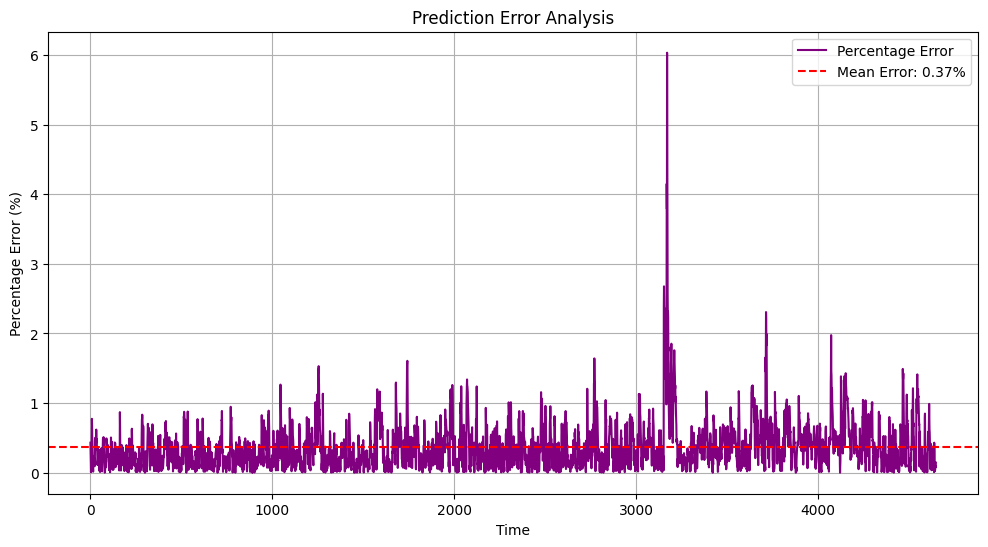

In [26]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(percentage_error, label='Percentage Error', color='purple')
plt.axhline(y=mean_percentage_error, color='r', linestyle='--', label=f'Mean Error: {mean_percentage_error:.2f}%')
plt.legend()
plt.title('Prediction Error Analysis')
plt.xlabel('Time')
plt.ylabel('Percentage Error (%)')
plt.grid(True)
plt.show()

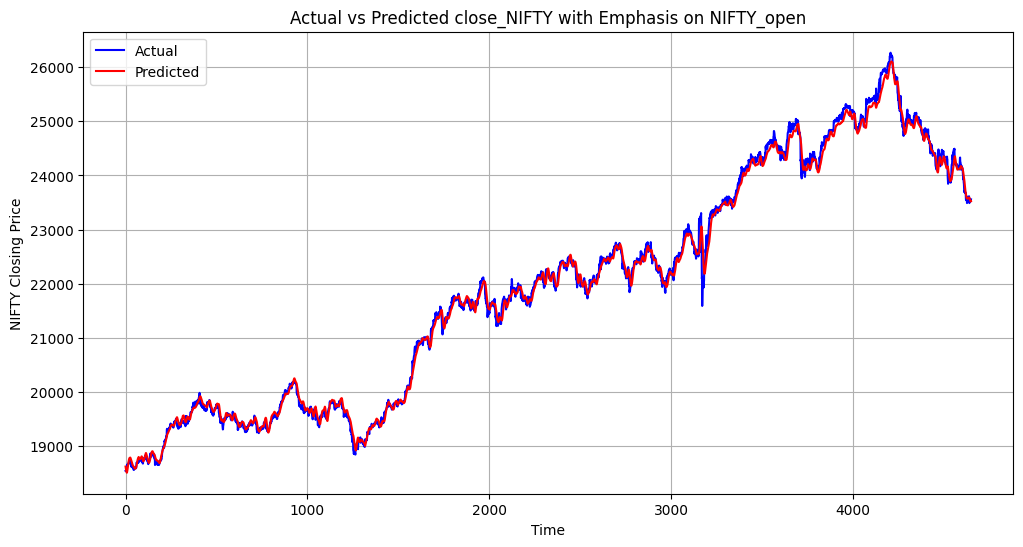

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label='Actual', color='blue')
plt.plot(y_pred_denormalized, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted close_NIFTY with Emphasis on NIFTY_open')
plt.xlabel('Time')
plt.ylabel('NIFTY Closing Price')
plt.grid(True)
plt.savefig('actual_vs_predicted.png', bbox_inches='tight', dpi=300)
plt.show()

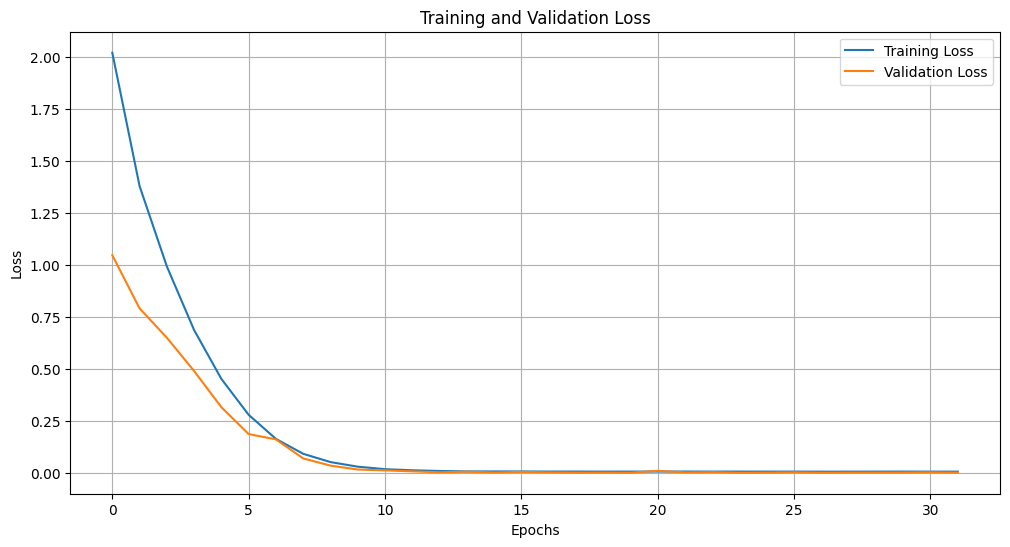

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('training_validation_loss.png', bbox_inches='tight', dpi=300)
plt.show()